<a href="https://colab.research.google.com/github/KARENCMP82/Python/blob/main/Clasificaci%C3%B3n_lluvia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Con los datos meteológicos de un día, queremos predecir si lloverá al día siguiente.  
Lloverá al día siguiente del úlitmo día del dataset?**

# Imports

Librerias

In [ ]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
pip install shap

In [ ]:
# gestión de datos
import numpy as np
import pandas as pd

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# modelos
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier: el equivalente del Adaline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# interpretabilidad
import shap

# para visualizar mas columnas en un df
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")  # inhabilita warnings

np.random.seed(42)

Datos

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TIC/Data science/Master Data Science Nuclio - profesor/Aprendizaje supervisado - Ejercicios/Clasificación - lluvia/lluvia.csv', index_col=0)

In [ ]:
df.shape

(6812, 27)

In [ ]:
df.head()

,fecha,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,viento_dir,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,SW,0,0,0,0,0
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,SE,1,0,0,0,0
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,W,1,1,0,0,0
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,W,0,0,0,0,0
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,N,0,1,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6812 entries, 0 to 6811
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fecha             6812 non-null   object 
 1   temperatura_max   6810 non-null   float64
 2   temperatura_med   6809 non-null   float64
 3   temperatura_min   6810 non-null   float64
 4   rocio_max         6810 non-null   float64
 5   rocio_med         6810 non-null   float64
 6   rocio_min         6810 non-null   float64
 7   humedad_max       6810 non-null   float64
 8   humedad_med       6810 non-null   float64
 9   humedad_min       6810 non-null   float64
 10  presion_max       6812 non-null   int64  
 11  presion_med       6812 non-null   int64  
 12  presion_min       6812 non-null   int64  
 13  visibilidad_max   5872 non-null   float64
 14  visibilidad_med   5872 non-null   float64
 15  visibilidad_min   5872 non-null   float64
 16  viento_max        6812 non-null   int64  
 17  

Como queremos construir un modelo capaz de predecir si llueve al dia siguiente (D+1), utilizaremos la funcion **shift()** para desplazar 1 fila (=1 dia) cada valor de 'ind_lluvia' en el dataset.  
En esta problemática, queremos usar los atributos de un día y el indicador de lluvia del día siguiente.

In [ ]:
# cambiamos el tipo de la variable fecha a formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])

In [ ]:
# ordenamos el dataset por la fecha
df.sort_values('fecha', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6812 entries, 0 to 6811
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             6812 non-null   datetime64[ns]
 1   temperatura_max   6810 non-null   float64       
 2   temperatura_med   6809 non-null   float64       
 3   temperatura_min   6810 non-null   float64       
 4   rocio_max         6810 non-null   float64       
 5   rocio_med         6810 non-null   float64       
 6   rocio_min         6810 non-null   float64       
 7   humedad_max       6810 non-null   float64       
 8   humedad_med       6810 non-null   float64       
 9   humedad_min       6810 non-null   float64       
 10  presion_max       6812 non-null   int64         
 11  presion_med       6812 non-null   int64         
 12  presion_min       6812 non-null   int64         
 13  visibilidad_max   5872 non-null   float64       
 14  visibilidad_med   5872 non-nu

In [ ]:
# creamos la variable lluvia_D+1, que es el indicador de lluvia del día siguiente de la observación
df['lluvia_D+1'] = df['ind_lluvia'].shift(-1)

In [ ]:
# creamos la variable target para facilitar el codigo
target = 'lluvia_D+1'

In [ ]:
df.head()

,fecha,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,viento_dir,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,SW,0,0,0,0,0,1.0
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,SE,1,0,0,0,0,1.0
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,W,1,1,0,0,0,0.0
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,W,0,0,0,0,0,0.0
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,N,0,1,0,0,0,0.0


In [ ]:
df.tail()

,fecha,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,viento_dir,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1
6807,2015-12-27,14.0,7.0,-1.0,6.0,2.0,-2.0,100.0,77.0,30.0,1035,1030,1027,31.0,14.0,5.0,14,6,NaN,0.00,8.0,NE,0,0,0,1,0,1.0
6808,2015-12-28,15.0,8.0,2.0,8.0,4.0,1.0,100.0,78.0,34.0,1031,1027,1023,31.0,14.0,8.0,27,8,45.0,0.51,7.0,SW,1,0,0,0,0,1.0
6809,2015-12-29,11.0,8.0,5.0,9.0,7.0,5.0,100.0,89.0,66.0,1034,1030,1026,31.0,9.0,0.0,14,8,32.0,2.03,5.0,S,1,0,0,1,0,0.0
6810,2015-12-30,9.0,8.0,6.0,7.0,6.0,5.0,93.0,87.0,70.0,1034,1029,1025,19.0,10.0,6.0,14,5,34.0,0.00,6.0,W,0,0,0,0,0,1.0
6811,2015-12-31,12.0,10.0,7.0,10.0,8.0,7.0,100.0,90.0,70.0,1027,1025,1024,31.0,8.0,2.0,14,6,NaN,0.25,6.0,NW,1,0,0,0,0,NaN


# Preprocessing

## Data cleaning

In [ ]:
# comprobamos duplicados
df.duplicated().sum()

0

## Nulos

In [ ]:
df.isna().sum()

,0
fecha,0
temperatura_max,2
temperatura_med,3
temperatura_min,2
rocio_max,2
rocio_med,2
rocio_min,2
humedad_max,2
humedad_med,2
humedad_min,2


In [ ]:
# hay 3 registros sin la temperatura ni la humedad informada, como son MUY POCOS registros optamos por eliminarlos en lugar de imputar un valor
df.dropna(axis=0, subset=['temperatura_med'], inplace=True)

In [ ]:
# lista de columnas con nulos
cols_null = list(df.columns[df.isna().sum() >0])
cols_null

['visibilidad_max',
 'visibilidad_med',
 'visibilidad_min',
 'racha_viento_max',
 'nubes',
 'lluvia_D+1']

In [ ]:
# quitamos la variable 'lluvia_D+1' del listado de variables para imputar nulos, al ser justamente el valor que queremos adivinar
cols_null.remove(target)
cols_null

['visibilidad_max',
 'visibilidad_med',
 'visibilidad_min',
 'racha_viento_max',
 'nubes']

In [ ]:
# rellenamos los nulos con el datos del día anterior
# OJO: solo se puede hacer este metodo en datasets ordenados!
for col in cols_null:
  df[col] = df[col].fillna(method='ffill')

In [ ]:
# comprobamos el total de nulos
df.isnull().sum().sum()

2

In [ ]:
# el primer registro tiene un nulo en racha_viento_max: rellenamos con el dato del día siguiente
df.head(1)

,fecha,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,viento_dir,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,SW,0,0,0,0,0,1.0


In [ ]:
for col in cols_null:
  df[col] = df[col].fillna(method='bfill')

In [ ]:
# solo nos queda el nulo de la última fila, el dato que queremos adivinar: si llueve al día siguiente
df.isna().sum()

,0
fecha,0
temperatura_max,0
temperatura_med,0
temperatura_min,0
rocio_max,0
rocio_med,0
rocio_min,0
humedad_max,0
humedad_med,0
humedad_min,0


## Variables categoricas

In [ ]:
# variable de formato no númerico
list(df.select_dtypes(include=['object', 'datetime64[ns]']).columns)

['fecha', 'viento_dir']

### fecha

In [ ]:
# eliminamos la fecha y creamos 2 variables: día del mes y mes del año
df['dia'] = df['fecha'].dt.day
df['mes'] = df['fecha'].dt.month

df.drop('fecha', axis=1, inplace=True)

### viento_dir

In [ ]:
df['viento_dir'].value_counts()

,count
viento_dir,
N,1964
SW,1133
W,978
NE,809
NW,732
S,605
SE,326
E,262


In [ ]:
# tratamos esta variable con One Hot Encoding
df = pd.get_dummies(df, columns=['viento_dir'])

In [ ]:
# ya no quedan variable que no sean numéricas
list(df.select_dtypes(include=['object', 'datetime64[ns]']).columns)

[]

## alta correlación

In [ ]:
df

,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
0,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,47.0,0.00,6.0,0,0,0,0,0,1.0,1,1,False,False,False,False,False,False,True,False
1,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.00,5.0,1,0,0,0,0,1.0,2,1,False,False,False,False,False,True,False,False
2,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,47.0,0.00,6.0,1,1,0,0,0,0.0,3,1,False,False,False,False,False,False,False,True
3,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.00,2.0,0,0,0,0,0,0.0,4,1,False,False,False,False,False,False,False,True
4,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,40.0,0.00,7.0,0,1,0,0,0,0.0,5,1,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,14.0,7.0,-1.0,6.0,2.0,-2.0,100.0,77.0,30.0,1035,1030,1027,31.0,14.0,5.0,14,6,23.0,0.00,8.0,0,0,0,1,0,1.0,27,12,False,False,True,False,False,False,False,False
6808,15.0,8.0,2.0,8.0,4.0,1.0,100.0,78.0,34.0,1031,1027,1023,31.0,14.0,8.0,27,8,45.0,0.51,7.0,1,0,0,0,0,1.0,28,12,False,False,False,False,False,False,True,False
6809,11.0,8.0,5.0,9.0,7.0,5.0,100.0,89.0,66.0,1034,1030,1026,31.0,9.0,0.0,14,8,32.0,2.03,5.0,1,0,0,1,0,0.0,29,12,False,False,False,False,True,False,False,False
6810,9.0,8.0,6.0,7.0,6.0,5.0,93.0,87.0,70.0,1034,1029,1025,19.0,10.0,6.0,14,5,34.0,0.00,6.0,0,0,0,0,0,1.0,30,12,False,False,False,False,False,False,False,True


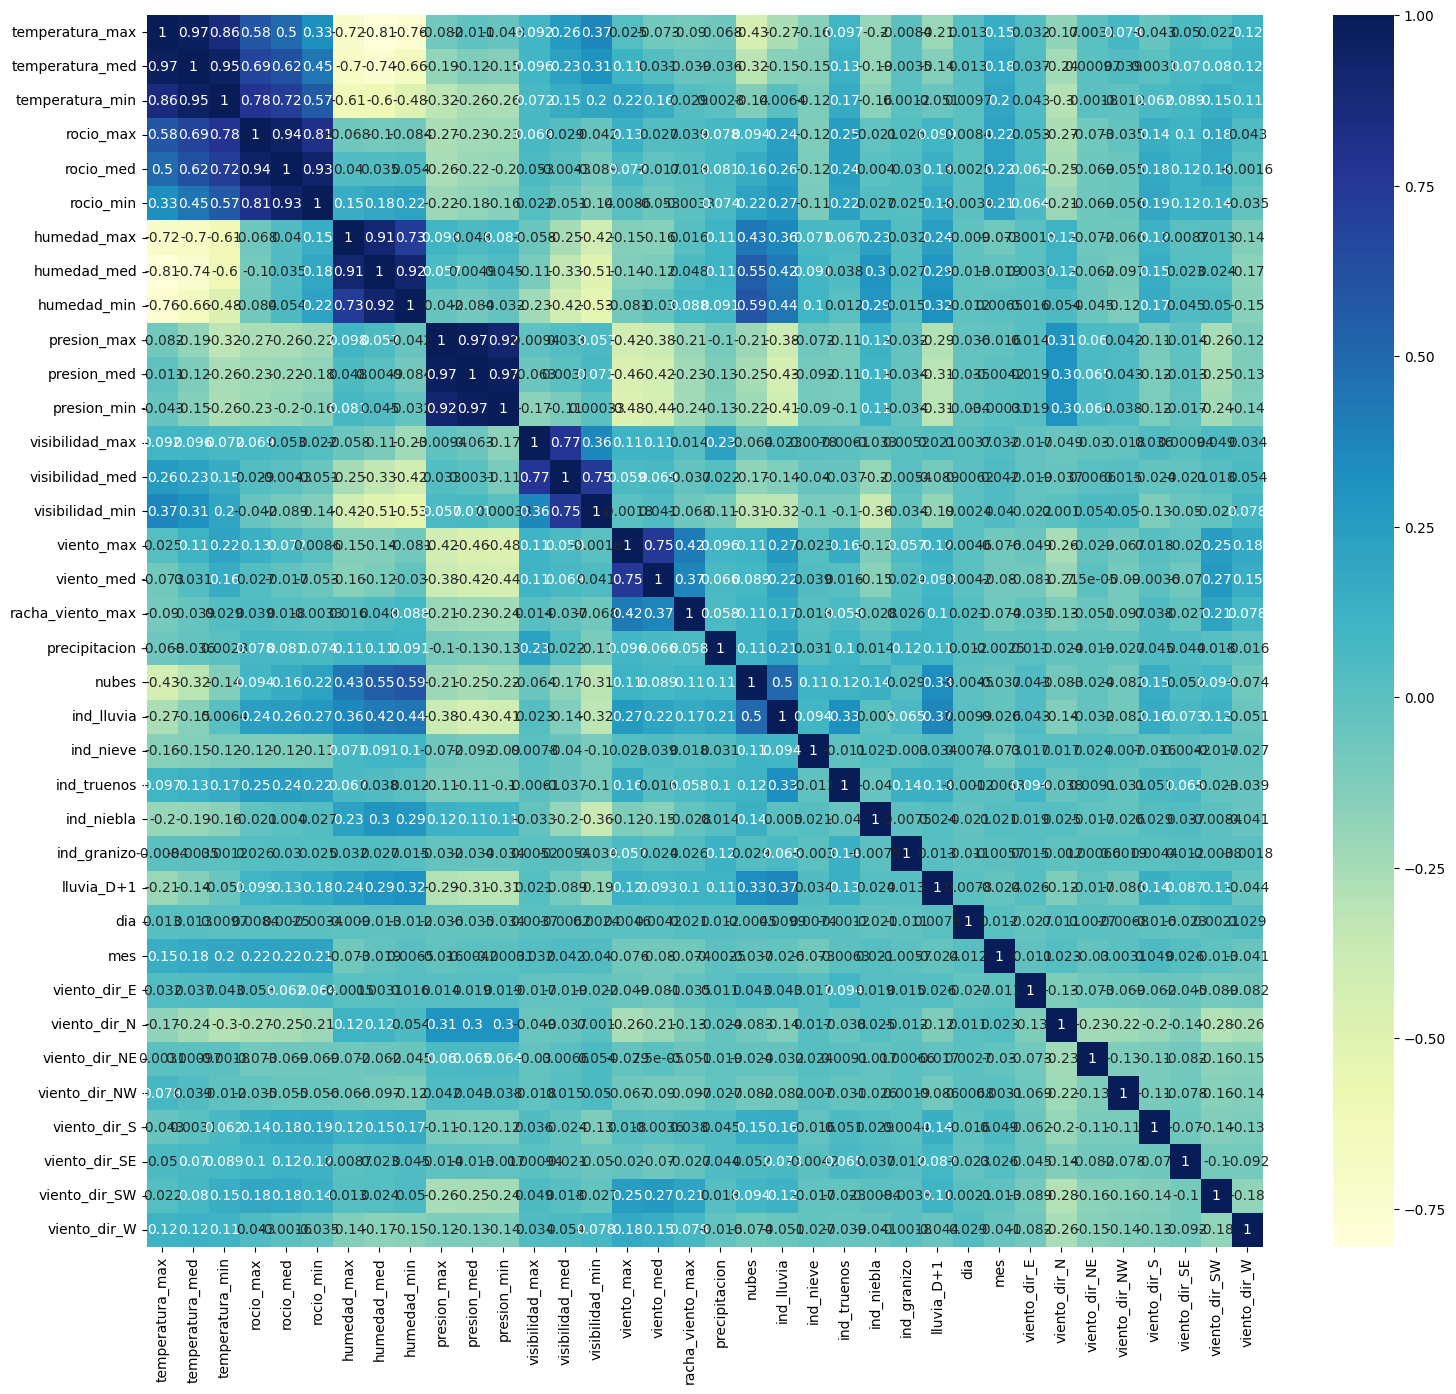

In [ ]:
df_corr = df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(data=df_corr, annot=True, cmap='YlGnBu')
plt.show()

In [ ]:
# sacamos los pares de variables muy correlacionadas (positiva o negativamente)

# creamos un dataframe triangulo de las correlaciones para evitar que se repitan los valores
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df.columns)
df_triangulo.index = df.columns
df_triangulo

,temperatura_max,temperatura_med,temperatura_min,rocio_max,rocio_med,rocio_min,humedad_max,humedad_med,humedad_min,presion_max,presion_med,presion_min,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
temperatura_max,0.0,0.970983,0.856360,0.583877,0.496060,0.329613,-0.718570,-0.806047,-0.761472,-0.081776,-0.011158,-0.042675,0.091798,0.263147,0.370385,0.025275,-0.073332,-0.090048,-0.068187,-0.431087,-0.269568,-0.156819,0.097450,-0.204514,-0.008369,-0.207123,0.012555,0.148617,0.032278,-0.174033,0.003104,0.077675,-0.043162,0.050143,0.021661,0.117126
temperatura_med,0.0,0.000000,0.951917,0.691818,0.615279,0.448551,-0.695012,-0.742891,-0.663245,-0.191302,-0.123744,-0.145113,0.096040,0.230792,0.308714,0.114279,0.031273,-0.038840,-0.036425,-0.316751,-0.153342,-0.145712,0.130728,-0.193117,-0.003546,-0.144188,0.012815,0.179199,0.037213,-0.235680,0.000965,0.039085,0.003098,0.069991,0.079581,0.118988
temperatura_min,0.0,0.000000,0.000000,0.775725,0.720387,0.567482,-0.608727,-0.601080,-0.479987,-0.320078,-0.260227,-0.264569,0.072118,0.154538,0.197980,0.216677,0.159707,0.029108,0.002782,-0.142022,0.006391,-0.118552,0.165382,-0.162215,0.001190,-0.051082,0.009672,0.202681,0.043114,-0.295606,-0.001794,-0.012481,0.062017,0.088682,0.148370,0.109021
rocio_max,0.0,0.000000,0.000000,0.000000,0.944166,0.810468,-0.068217,-0.100198,-0.084253,-0.269693,-0.231851,-0.225038,0.068847,0.028794,-0.041667,0.134779,0.027226,0.039492,0.078267,0.093509,0.237519,-0.122863,0.249708,-0.021245,0.026252,0.099091,0.008377,0.218358,0.052519,-0.268430,-0.072945,-0.034545,0.142024,0.104812,0.182510,0.042906
rocio_med,0.0,0.000000,0.000000,0.000000,0.000000,0.927185,0.039839,0.034863,0.053894,-0.258027,-0.218246,-0.201624,0.052692,-0.004283,-0.088754,0.071887,-0.017313,0.017811,0.081447,0.158063,0.255347,-0.119863,0.244328,0.003954,0.029648,0.132275,0.002527,0.220019,0.061691,-0.252169,-0.068611,-0.055448,0.177004,0.120535,0.177771,-0.001583
rocio_min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.151132,0.182423,0.223756,-0.217388,-0.183522,-0.159446,0.022123,-0.051472,-0.138294,0.008596,-0.052617,-0.003310,0.074120,0.223116,0.274460,-0.109241,0.223993,0.026653,0.024788,0.175036,-0.003395,0.208890,0.063712,-0.206536,-0.068537,-0.056261,0.192160,0.124663,0.138897,-0.034516
humedad_max,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.906903,0.728600,0.098063,0.048311,0.081368,-0.058047,-0.250540,-0.417956,-0.147376,-0.156922,0.015720,0.106603,0.433871,0.364389,0.070715,0.066880,0.228071,0.032265,0.236970,-0.008994,-0.072830,-0.001527,0.117138,-0.072006,-0.065513,0.118531,0.008658,0.013448,-0.141895
humedad_med,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.919701,0.057481,0.004868,0.045016,-0.112476,-0.334895,-0.507675,-0.138650,-0.116347,0.047971,0.114357,0.546485,0.423608,0.091097,0.037602,0.299724,0.026849,0.291614,-0.013063,-0.018768,0.003101,0.115076,-0.062302,-0.096917,0.151774,0.023442,0.024328,-0.170511
humedad_min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.041588,-0.083599,-0.032120,-0.229882,-0.417345,-0.529721,-0.080861,-0.029984,0.088355,0.090651,0.594486,0.438790,0.100534,0.011997,0.286523,0.015344,0.316341,-0.012496,0.006508,0.015935,0.054319,-0.045398,-0.115076,0.166400,0.044768,0.049529,-0.150235
presion_max,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.973039,0.916791,-0.009384,0.033001,0.056519,-0.417705,-0.380242,-0.206783,-0.102330,-0.214395,-0.381839,-0.071571,-0.114392,0.118711,-0.032474,-0.289282,-0.035747,-0.016001,0.014463,0.307778,0.060058,0.041815,-0.114519,-0.013654,-0.256178,-0.124580


In [ ]:
# Seleccionamos los pares de variables cuya correlación absoluta supere el umbral de 0.9
df_altas_correlaciones = df_triangulo.stack().reset_index()
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.9]
df_altas_correlaciones

,variable1,variable2,correlacion
1,temperatura_max,temperatura_med,0.970983
38,temperatura_med,temperatura_min,0.951917
112,rocio_max,rocio_med,0.944166
149,rocio_med,rocio_min,0.927185
223,humedad_max,humedad_med,0.906903
260,humedad_med,humedad_min,0.919701
334,presion_max,presion_med,0.973039
335,presion_max,presion_min,0.916791
371,presion_med,presion_min,0.968591


In [ ]:
# sacamos las correlaciones de las variables con la target
corr_con_target = df.corr()[target]
corr_con_target

,lluvia_D+1
temperatura_max,-0.207123
temperatura_med,-0.144188
temperatura_min,-0.051082
rocio_max,0.099091
rocio_med,0.132275
rocio_min,0.175036
humedad_max,0.236970
humedad_med,0.291614
humedad_min,0.316341
presion_max,-0.289282


In [ ]:
# añadimos las correlaciones al DataFrame de altas correlaciones
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target
1,temperatura_max,temperatura_med,0.970983,-0.207123,-0.144188
38,temperatura_med,temperatura_min,0.951917,-0.144188,-0.051082
112,rocio_max,rocio_med,0.944166,0.099091,0.132275
149,rocio_med,rocio_min,0.927185,0.132275,0.175036
223,humedad_max,humedad_med,0.906903,0.236970,0.291614
260,humedad_med,humedad_min,0.919701,0.291614,0.316341
334,presion_max,presion_med,0.973039,-0.289282,-0.309912
335,presion_max,presion_min,0.916791,-0.289282,-0.307047
371,presion_med,presion_min,0.968591,-0.309912,-0.307047


In [ ]:
# añadimos la variable menos correlacionada con la target del par de variables altamente correlaciones
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(
    lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
1,temperatura_max,temperatura_med,0.970983,-0.207123,-0.144188,temperatura_med
38,temperatura_med,temperatura_min,0.951917,-0.144188,-0.051082,temperatura_min
112,rocio_max,rocio_med,0.944166,0.099091,0.132275,rocio_max
149,rocio_med,rocio_min,0.927185,0.132275,0.175036,rocio_med
223,humedad_max,humedad_med,0.906903,0.236970,0.291614,humedad_max
260,humedad_med,humedad_min,0.919701,0.291614,0.316341,humedad_med
334,presion_max,presion_med,0.973039,-0.289282,-0.309912,presion_max
335,presion_max,presion_min,0.916791,-0.289282,-0.307047,presion_max
371,presion_med,presion_min,0.968591,-0.309912,-0.307047,presion_min


In [ ]:
# vemos que hay grupos de 3 variables altamente correlaciondas (max, min, med)
# eliminamos las 2 menos correlacionadas con la target quedandonos con la que aporta más valor al modelo
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))
var_menos_corr

['temperatura_med',
 'presion_max',
 'temperatura_min',
 'humedad_med',
 'humedad_max',
 'presion_min',
 'rocio_med',
 'rocio_max']

In [ ]:
# eliminamos las variables altamente correlacionadas que aportan menos valor del dataset
df.drop(columns=var_menos_corr, inplace=True)
df

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_nieve,ind_truenos,ind_niebla,ind_granizo,lluvia_D+1,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
0,7.0,2.0,76.0,1008,10.0,9.0,4.0,13,6,47.0,0.00,6.0,0,0,0,0,0,1.0,1,1,False,False,False,False,False,False,True,False
1,7.0,0.0,71.0,1003,10.0,9.0,4.0,26,8,47.0,0.00,5.0,1,0,0,0,0,1.0,2,1,False,False,False,False,False,True,False,False
2,5.0,-1.0,70.0,999,10.0,10.0,7.0,27,19,47.0,0.00,6.0,1,1,0,0,0,0.0,3,1,False,False,False,False,False,False,False,True
3,7.0,-4.0,49.0,1010,10.0,10.0,10.0,27,19,40.0,0.00,2.0,0,0,0,0,0,0.0,4,1,False,False,False,False,False,False,False,True
4,2.0,-3.0,86.0,1008,10.0,5.0,1.0,14,6,40.0,0.00,7.0,0,1,0,0,0,0.0,5,1,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,14.0,-2.0,30.0,1030,31.0,14.0,5.0,14,6,23.0,0.00,8.0,0,0,0,1,0,1.0,27,12,False,False,True,False,False,False,False,False
6808,15.0,1.0,34.0,1027,31.0,14.0,8.0,27,8,45.0,0.51,7.0,1,0,0,0,0,1.0,28,12,False,False,False,False,False,False,True,False
6809,11.0,5.0,66.0,1030,31.0,9.0,0.0,14,8,32.0,2.03,5.0,1,0,0,1,0,0.0,29,12,False,False,False,False,True,False,False,False
6810,9.0,5.0,70.0,1029,19.0,10.0,6.0,14,5,34.0,0.00,6.0,0,0,0,0,0,1.0,30,12,False,False,False,False,False,False,False,True


## baja varianza

In [ ]:
var_poca_varianza = []
print('baja varianza:')

for col in df.columns:
  if df[col].var() < 0.01:
    print(col, df[col].var())
    var_poca_varianza.append(col)
print('eliminar', var_poca_varianza)

baja varianza:
ind_nieve 0.007724362188083214
ind_granizo 0.0011737075022878922
eliminar ['ind_nieve', 'ind_granizo']


In [ ]:
# eliminamos las variables con poca varianza
df.drop(columns=var_poca_varianza, inplace=True)
df

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_truenos,ind_niebla,lluvia_D+1,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
0,7.0,2.0,76.0,1008,10.0,9.0,4.0,13,6,47.0,0.00,6.0,0,0,0,1.0,1,1,False,False,False,False,False,False,True,False
1,7.0,0.0,71.0,1003,10.0,9.0,4.0,26,8,47.0,0.00,5.0,1,0,0,1.0,2,1,False,False,False,False,False,True,False,False
2,5.0,-1.0,70.0,999,10.0,10.0,7.0,27,19,47.0,0.00,6.0,1,0,0,0.0,3,1,False,False,False,False,False,False,False,True
3,7.0,-4.0,49.0,1010,10.0,10.0,10.0,27,19,40.0,0.00,2.0,0,0,0,0.0,4,1,False,False,False,False,False,False,False,True
4,2.0,-3.0,86.0,1008,10.0,5.0,1.0,14,6,40.0,0.00,7.0,0,0,0,0.0,5,1,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,14.0,-2.0,30.0,1030,31.0,14.0,5.0,14,6,23.0,0.00,8.0,0,0,1,1.0,27,12,False,False,True,False,False,False,False,False
6808,15.0,1.0,34.0,1027,31.0,14.0,8.0,27,8,45.0,0.51,7.0,1,0,0,1.0,28,12,False,False,False,False,False,False,True,False
6809,11.0,5.0,66.0,1030,31.0,9.0,0.0,14,8,32.0,2.03,5.0,1,0,1,0.0,29,12,False,False,False,False,True,False,False,False
6810,9.0,5.0,70.0,1029,19.0,10.0,6.0,14,5,34.0,0.00,6.0,0,0,0,1.0,30,12,False,False,False,False,False,False,False,True


## dataset a entrenar y dataset a predecir

In [ ]:
# separamos los datos a entrenar de los a predecir

# quitamos la última fila del dataset para entrenar
df_entrenar = df.head(-1)

# nos quedamos solo con la última fila para predecir
df_predecir = df.tail(1)

# quitamos la variable lluvia_D+1 del dataset a predecir
df_predecir.drop(target, axis=1, inplace=True)

In [ ]:
df_entrenar

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_truenos,ind_niebla,lluvia_D+1,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
0,7.0,2.0,76.0,1008,10.0,9.0,4.0,13,6,47.0,0.00,6.0,0,0,0,1.0,1,1,False,False,False,False,False,False,True,False
1,7.0,0.0,71.0,1003,10.0,9.0,4.0,26,8,47.0,0.00,5.0,1,0,0,1.0,2,1,False,False,False,False,False,True,False,False
2,5.0,-1.0,70.0,999,10.0,10.0,7.0,27,19,47.0,0.00,6.0,1,0,0,0.0,3,1,False,False,False,False,False,False,False,True
3,7.0,-4.0,49.0,1010,10.0,10.0,10.0,27,19,40.0,0.00,2.0,0,0,0,0.0,4,1,False,False,False,False,False,False,False,True
4,2.0,-3.0,86.0,1008,10.0,5.0,1.0,14,6,40.0,0.00,7.0,0,0,0,0.0,5,1,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,12.0,-2.0,56.0,1033,14.0,7.0,3.0,11,5,23.0,0.00,5.0,0,0,0,0.0,26,12,False,True,False,False,False,False,False,False
6807,14.0,-2.0,30.0,1030,31.0,14.0,5.0,14,6,23.0,0.00,8.0,0,0,1,1.0,27,12,False,False,True,False,False,False,False,False
6808,15.0,1.0,34.0,1027,31.0,14.0,8.0,27,8,45.0,0.51,7.0,1,0,0,1.0,28,12,False,False,False,False,False,False,True,False
6809,11.0,5.0,66.0,1030,31.0,9.0,0.0,14,8,32.0,2.03,5.0,1,0,1,0.0,29,12,False,False,False,False,True,False,False,False


In [ ]:
df_predecir

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_truenos,ind_niebla,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
6811,12.0,7.0,70.0,1025,31.0,8.0,2.0,14,6,34.0,0.25,6.0,1,0,0,31,12,False,False,False,True,False,False,False,False


In [ ]:
df_predecir.shape

(1, 25)

# Rebalanceo

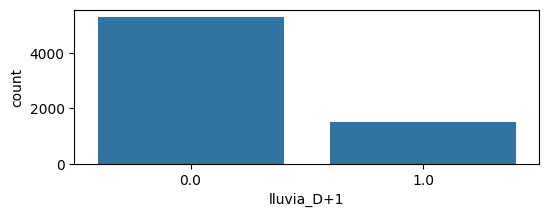

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(data=df_entrenar, x=target)
plt.show()

In [ ]:
# proporción de cada clase de la target
df_entrenar[target].value_counts(normalize=True).mul(100)

,proportion
lluvia_D+1,
0.0,77.967098
1.0,22.032902


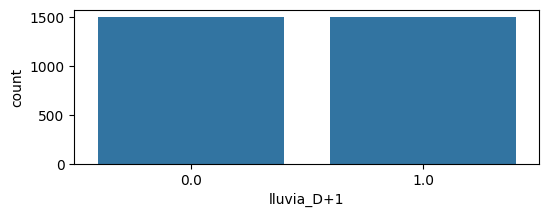

3000 observaciones para entrenar


In [ ]:
# separamos las 2 categorias
df_lluvia = df_entrenar[df_entrenar[target] == 1]
df_no_lluvia = df_entrenar[df_entrenar[target] == 0]

# se selecciona de forma aleatoria el mismo número de dias de no lluvia que días de lluvia para equilibrar el dataset, sin posibilidad de repetir, con sample
df_no_lluvia = df_no_lluvia.sample(len(df_lluvia), replace=False, random_state=42)

# se juntan los dataframes de lluvia y no lluvia en el df_entrenar con concat
df_entrenar = pd.concat([df_lluvia, df_no_lluvia])

fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(data=df_entrenar, x=target)
plt.show()

print(len(df_entrenar), 'observaciones para entrenar')

# MODELO

## feature importance

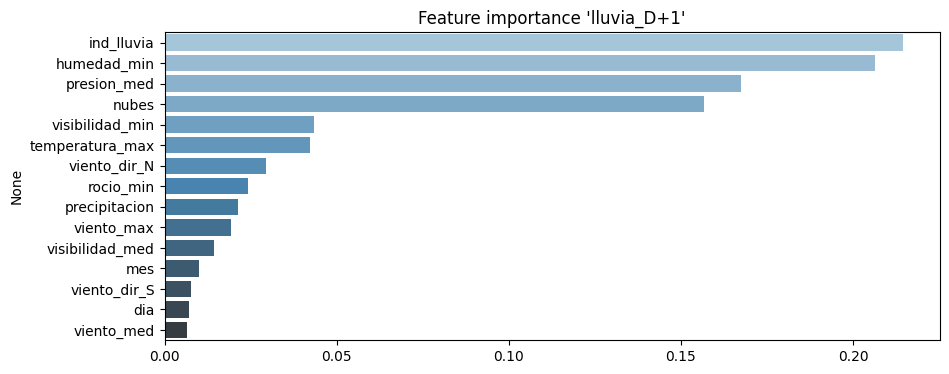

In [ ]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df_entrenar.drop(target,axis=1), df_entrenar[target]
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Plotea las 15 mejores Features importances
num_features = 15
features = clf.feature_importances_
columnas = x.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## split train-test

In [ ]:
# se guarda la target como 'y' y las features como 'X'
y = df_entrenar[target]
X = df_entrenar.drop(target, axis=1)

In [ ]:
# se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('nº observaciones de train:', len(y_train))
print('nº observaciones de test: ', len(y_test))

nº observaciones de train: 2100
nº observaciones de test:  900


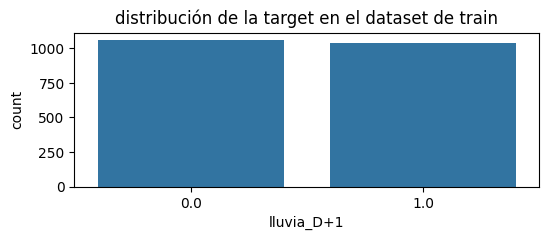

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(x=y_train)
plt.title('distribución de la target en el dataset de train')
plt.show()

In [ ]:
# repartición de la target en el data set de train
y_train.value_counts(normalize=True).mul(100)

,proportion
lluvia_D+1,
0.0,50.52381
1.0,49.47619


In [ ]:
# repartición de la target en el data set de test
y_test.value_counts(normalize=True).mul(100)

,proportion
lluvia_D+1,
1.0,51.222222
0.0,48.777778


## estandarización

In [ ]:
# guardo las columnas del dataset en una lista antes de standarizar
# el metodo scaler quita el nombre de las variables
# para la interpretabilidad, si el modelo ganador es un arbol de decisión, conviene guardar el nombre de las variables
variables_entrenadas = X.columns

In [ ]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
X_predecir = scaler.transform(df_predecir)

## competición de modelos

In [ ]:
# añadimos en una lista los modelos que queremos poner a competir

modelos = []
modelos.append(('Perceptron', Perceptron(random_state=42)))
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_seed=42)))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

Utilizaremos la métrica AUC para evaluar el modelo y compararlos.


&#x26a0;&#xfe0f;  
**El metodo roc_auc_score requiere probabilidades para calcular el AUC, no predicciones binarias.**  
**Se saca el AUC comparando la target del test real (y_test) con la predicción (y_pred) hecha con PREDIC_PROBA, no con predict.**

In [ ]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC'])

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    # al AUC se saca con predict_proba.
    # para el perceptron, usaremos decision_function, el equivalente del predict_proba para este algoritmo
    if nombre == 'Perceptron':
      y_pred = modelo.decision_function(X_test)
    else:
      y_pred = modelo.predict_proba(X_test)[:, 1]

    # calculamos el AUC
    auc = metrics.roc_auc_score(y_test, y_pred)

    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'AUC': auc}, index=[0])
                                  ])
    print(modelo, auc)

metricas_modelos.sort_values('AUC', ascending=False)

Perceptron(random_state=42) 0.7389403050711784
SGDClassifier(loss='log_loss', random_state=42) 0.7633054812999372
GradientBoostingClassifier(random_state=42) 0.8145756229648334
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) 0.788130191373611
<catboost.core.CatBoostClassifier object at 0x7c2

,modelo,AUC
0,CatBoostClassifier,0.819645
0,LogisticRegression,0.818865
0,GradientBoostingClassifier,0.814576
0,XGBClassifier,0.788130
0,SGDClassifier,0.763305
0,Perceptron,0.738940


CatBoostClassifier	0.819645  
LogisticRegression	0.818865  
GradientBoostingClassifier	0.814576  
XGBClassifier	0.788130  
SGDClassifier	0.763305  
Perceptron	0.738940  

&#x1f947; Tenemos un modelo ganador: el CatBoostClassifier

## hiperparametrizar el modelo ganador

In [ ]:
# gridsearch
parameters = {'learning_rate': [0.01, 0.03, 0.05, 0.1],
              'iterations': [300, 500, 800, 1000, 1200],
              'max_depth': [4, 5, 6, 7],
              'eval_metric': ['Logloss', 'AUC'],
              'verbose': [False]}

In [ ]:
modelo = CatBoostClassifier()

&#x231b; al tardar tanto, comento el código:

In [ ]:
# # se prueban todas las combinaciones de parametros
# modelo_grid = GridSearchCV(modelo,
#                            parameters,
#                            cv=2,
#                            verbose=True)

# modelo_grid.fit(X_train, y_train)

# # se imprime el modelo con los mejores parametros
# print('mejores parametros:')
# modelo_grid.best_params_

## entrenamiento del modelo final

Después de varias pruebas con multiples combinaciones de parametros, no conseguí mejorar la combinación de parametros por defecto.



In [ ]:
# selección del mejor modelo con los mejores parámetros
modelo =  CatBoostClassifier(verbose=False, random_seed=42)

# entrenamiento
modelo.fit(X_train, y_train)

In [ ]:
# Podemos sacar los parametros usado por el modelo
modelo.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'l

# Evaluación

In [ ]:
# evalucación sobre el dataset de train

# predicción en el dataset de train
y_pred_train = modelo.predict_proba(X_train)

# evaluación de la métrica
auc_train = metrics.roc_auc_score(y_train, y_pred_train[:,1])
print('auc train:', auc_train)

auc train: 0.9593270553956489


In [ ]:
# evalucación sobre el dataset de test

# predicción en el dataset de test
y_pred_test = modelo.predict_proba(X_test)

# evaluación de la métrica
auc_test = metrics.roc_auc_score(y_test, y_pred_test[:,1])
print('auc test:', auc_test)

auc test: 0.8196453189313119


El modelo tiene bastante overfitting, pero la métrica en el dataset de test es muy aceptable.

# (otras métricas)

Vamos ver como se calculan las otras métricas vistas en la parte teórica

In [ ]:
y_train_pred = modelo.predict(X_train)                        # predicciones del modelo en los datos de TRAIN
y_test_pred = modelo.predict(X_test)                          # predicciones del modelo en los datos de TEST

In [ ]:
y_train_pred_proba = modelo.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = modelo.predict_proba(X_test)[:, 1]        # probabilidad de éxito (1) segun el modelo en los datos de TEST

* ROC Curve

In [ ]:
# metricas para la curva ROC
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_pred_proba)

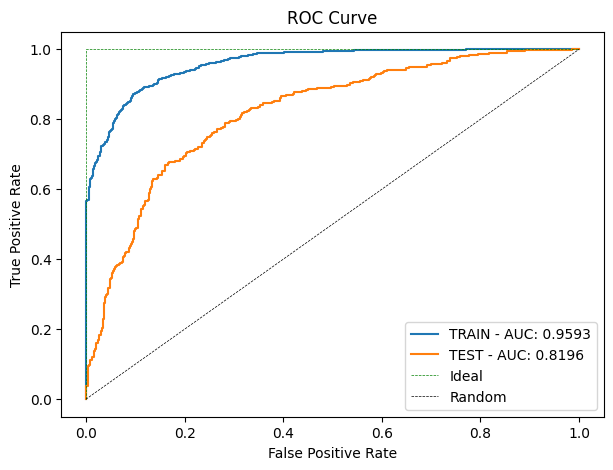

In [ ]:
#Plot
plt.figure(figsize=[7,5])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

* Confusion Matrix

In [ ]:
# creamos la matriz de confusión
cm_test = metrics.confusion_matrix(y_test, y_test_pred)

[]

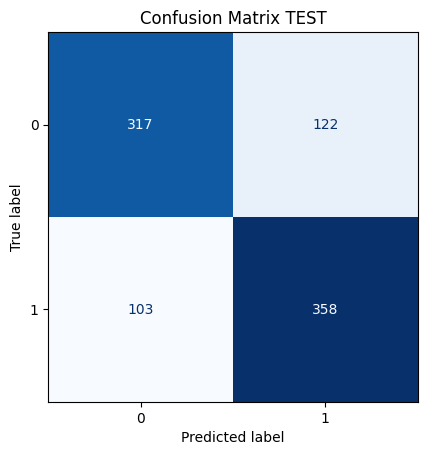

In [ ]:
# gráfico de la matriz de confusión en cantidades
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(colorbar = False, cmap = 'Blues')

plt.title('Confusion Matrix TEST')
plt.plot()

[]

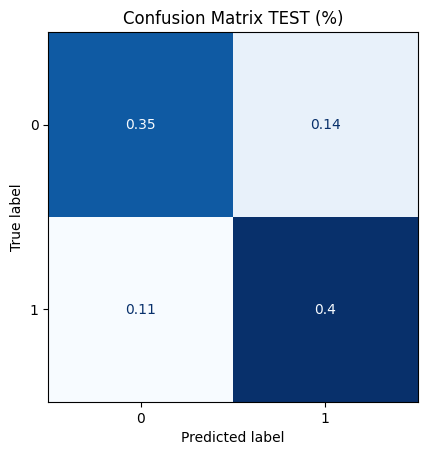

In [ ]:
# gráfico de la matriz de confusión en %
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test))
disp.plot(colorbar = False, cmap = 'Blues')

plt.title('Confusion Matrix TEST (%)')
plt.plot()

* Accuracy, Precision, Recall y F1-Score

In [ ]:
cm_test

array([[317, 122],
       [103, 358]])

In [ ]:
# creamos las variables de true positive, true negative, ...
TN = cm_test[0,0]
TP = cm_test[1,1]
FP = cm_test[0,1]
FN = cm_test[1,0]
total = len(y_test)

In [ ]:
# accuracy
accuracy = (TN+TP)/total

# precision
precision = TP/(TP+FP)

# recall
recall = TP/(TP+FN)

# f1_score
f1_score = 2/(1/recall + 1/precision)

In [ ]:
print('accuracy:', round(accuracy,4))
print('precision:', round(precision, 4))
print('recall:', round(recall, 4))
print('f1_score:', round(f1_score, 4))

accuracy: 0.75
precision: 0.7458
recall: 0.7766
f1_score: 0.7609


Con scikit-learn, se hace directemente:

In [ ]:
accuracy_sklearn = metrics.accuracy_score(y_test, y_test_pred)
precision_sklearn = metrics.precision_score(y_test, y_test_pred)
recall_sklearn = metrics.recall_score(y_test, y_test_pred)
f1_score_sklearn = metrics.f1_score(y_test, y_test_pred)

In [ ]:
print('accuracy:', round(accuracy_sklearn,4))
print('precision:', round(precision_sklearn, 4))
print('recall:', round(recall_sklearn, 4))
print('f1_score:', round(f1_score_sklearn, 4))

accuracy: 0.75
precision: 0.7458
recall: 0.7766
f1_score: 0.7609


# Interpretabilidad

## modelo lineal

entrenamos un modelo de regresion logística para ver un ejemplo de como sacar los parámetros

In [ ]:
modelo_reg_logistic = LogisticRegression(random_state=42)

# entrenamiento
modelo_reg_logistic.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Coeficientes (pesos) de las variables
print("Coeficientes:", modelo_reg_logistic.coef_[0])

# Intercept (constante)
print("Intercept:", modelo_reg_logistic.intercept_)

Coeficientes: [-0.51310388  0.32553854  0.10024504 -0.54185159  0.30861264 -0.29497376
 -0.00594955  0.13099512 -0.26293723  0.0135577   0.12527928  0.30889694
  0.08723163  0.24616312 -0.10317815 -0.01210663 -0.0573122   0.06468459
 -0.19325228  0.0142197  -0.06841849  0.10084713  0.14502369  0.06685616
 -0.02024988]
Intercept: [0.02510898]


In [ ]:
# creamos un dataframe con el nombre de las variables para facilitar la vista
coeficientes = pd.DataFrame()
coeficientes['variable'] = variables_entrenadas
coeficientes['coeficiente'] = modelo_reg_logistic.coef_[0]


dict_intercept = {'variable': ['intercept'],
                  'coeficiente':  modelo_reg_logistic.intercept_}
intercept = pd.DataFrame(dict_intercept)

coeficientes = pd.concat([coeficientes, intercept], ignore_index=True)
coeficientes

,variable,coeficiente
0,temperatura_max,-0.513104
1,rocio_min,0.325539
2,humedad_min,0.100245
3,presion_med,-0.541852
4,visibilidad_max,0.308613
5,visibilidad_med,-0.294974
6,visibilidad_min,-0.005950
7,viento_max,0.130995
8,viento_med,-0.262937
9,racha_viento_max,0.013558


## modelo de árbol de decisión

&#x26a0;&#xfe0f;
Ejecutar estas celdas solo si el modelo ganador es un modelo de árbol de desición: GradientBoostingClassifier, XGBClassifier o CatBoostClassifier

In [ ]:
# creamos un dataframe con los datos de X_test y las variables como columnas (por eso las guardamos antes)
df_X_test = pd.DataFrame(X_test, columns=variables_entrenadas)
df_X_test

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_truenos,ind_niebla,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
0,0.095650,0.205548,-0.840452,-0.535995,1.999609,1.148306,0.047831,0.125647,1.216093,-0.744708,-0.141098,-0.167515,-0.673266,-0.251577,-0.225945,0.120342,0.716616,-0.204124,-0.593483,-0.357519,-0.300571,-0.349849,-0.260030,-0.496277,2.549510
1,1.457445,0.827822,-1.038172,1.246176,1.999609,2.551473,0.257091,-0.862216,-0.660180,-0.744708,-0.141098,1.463619,1.485297,-0.251577,-0.225945,-0.559313,-0.427355,-0.204124,-0.593483,-0.357519,3.327005,-0.349849,-0.260030,-0.496277,-0.392232
2,1.797893,0.620397,-1.137032,0.503605,-0.492978,-0.254861,0.257091,-0.170712,-0.660180,0.025490,-0.141098,-1.254938,-0.673266,-0.251577,-0.225945,1.026549,0.430623,-0.204124,-0.593483,-0.357519,-0.300571,-0.349849,-0.260030,2.015004,-0.392232
3,-0.925696,-1.039000,0.988459,1.691719,-0.492978,-0.455313,-0.370690,-1.158575,-0.847808,0.256549,-0.141098,-1.254938,-0.673266,-0.251577,-0.225945,1.366376,1.288602,-0.204124,1.684970,-0.357519,-0.300571,-0.349849,-0.260030,-0.496277,-0.392232
4,-0.358282,0.620397,0.691879,3.028348,-0.492978,-0.856218,-1.207731,-1.257362,-0.847808,0.410589,-0.141098,-0.167515,-0.673266,-0.251577,4.425860,-0.559313,-1.285333,-0.204124,-0.593483,-0.357519,3.327005,-0.349849,-0.260030,-0.496277,-0.392232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1.684410,-0.001877,-1.285322,0.355091,-0.492978,-0.254861,0.257091,0.026860,-0.284926,-0.205570,-0.141098,-0.167515,-0.673266,-0.251577,-0.225945,0.799997,-0.141362,-0.204124,-0.593483,-0.357519,-0.300571,-0.349849,-0.260030,-0.496277,2.549510
896,-0.131316,1.450096,0.691879,-0.833024,-0.492978,-0.455313,-1.416991,0.323219,1.591348,0.564629,-0.141098,1.463619,1.485297,-0.251577,-0.225945,0.799997,-0.427355,-0.204124,-0.593483,-0.357519,-0.300571,-0.349849,-0.260030,2.015004,-0.392232
897,1.003513,-0.624151,-0.939312,-0.387481,-0.492978,-0.254861,0.257091,0.323219,-0.660180,-0.436629,-0.141098,-1.254938,-0.673266,-0.251577,-0.225945,-0.219485,0.716616,-0.204124,1.684970,-0.357519,-0.300571,-0.349849,-0.260030,-0.496277,-0.392232
898,-0.358282,1.450096,1.235609,-1.278567,-0.492978,-0.455313,-1.416991,-0.862216,-0.847808,0.410589,-0.141098,1.463619,1.485297,-0.251577,-0.225945,-1.352244,1.002609,4.898979,-0.593483,-0.357519,-0.300571,-0.349849,-0.260030,-0.496277,-0.392232


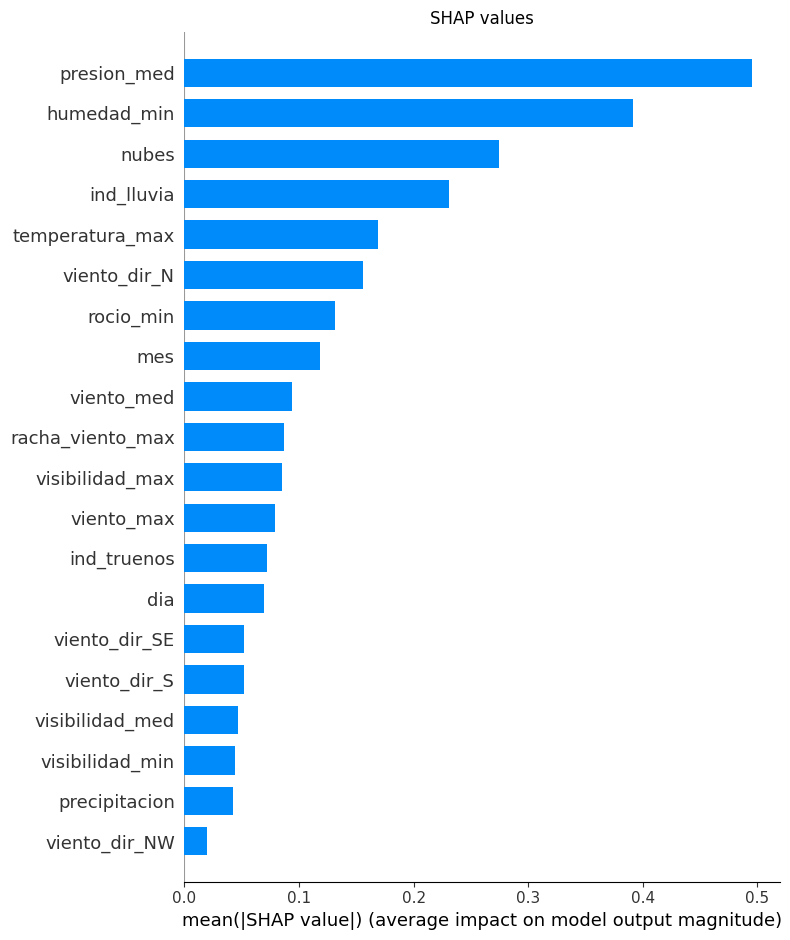

In [ ]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(df_X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

Los SHAP values nos indican ademas el sentido del impacto que tiene la variable en la predicción (positivo/negativo):
* Rojo a la derecha = POSITIVO (+)
* Rojo a la izquierda = NEGATIVO (-)

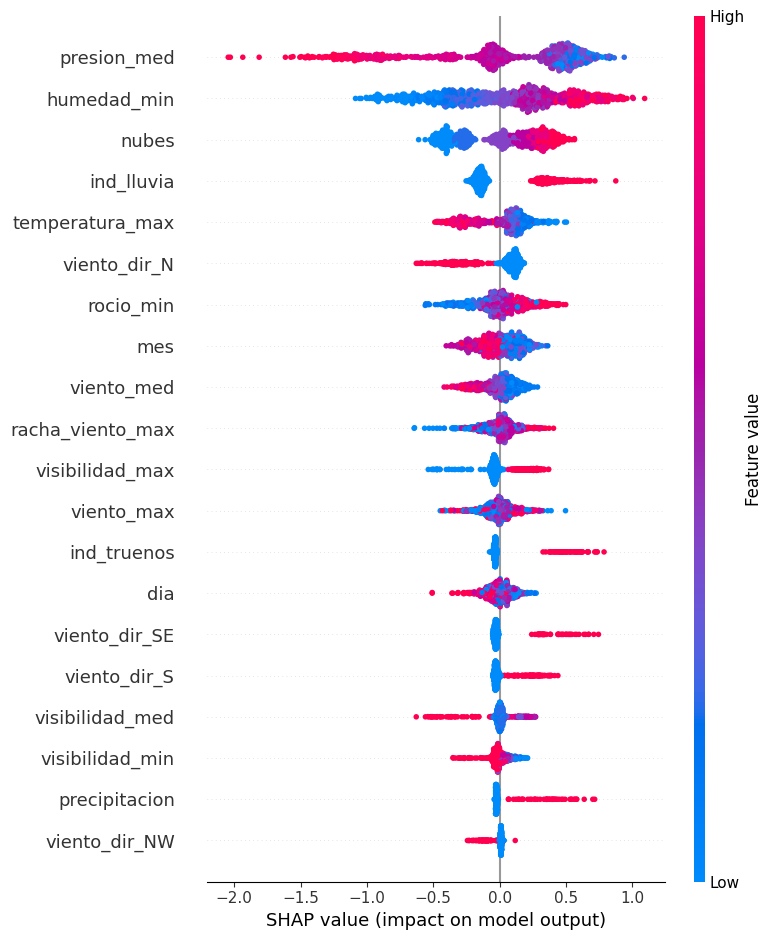

In [ ]:
shap.summary_plot(shap_values, df_X_test)

# PREDICCIÓN

In [ ]:
df_predecir

,temperatura_max,rocio_min,humedad_min,presion_med,visibilidad_max,visibilidad_med,visibilidad_min,viento_max,viento_med,racha_viento_max,precipitacion,nubes,ind_lluvia,ind_truenos,ind_niebla,dia,mes,viento_dir_E,viento_dir_N,viento_dir_NE,viento_dir_NW,viento_dir_S,viento_dir_SE,viento_dir_SW,viento_dir_W
6811,12.0,7.0,70.0,1025,31.0,8.0,2.0,14,6,34.0,0.25,6.0,1,0,0,31,12,False,False,False,True,False,False,False,False


In [ ]:
X_predecir

array([[-0.9256962 ,  1.03524677,  1.58161929,  1.2461765 ,  1.99960895,
        -0.65576576, -1.41699129, -0.86221649, -0.66018022, -0.82172813,
         0.0539939 ,  1.46361948,  1.4852969 , -0.2515773 , -0.2259448 ,
         1.70620379,  1.57459429, -0.20412415, -0.59348252, -0.3575186 ,
         3.32700549, -0.34984917, -0.26003011, -0.49627694, -0.39223227]])

Al haber hecho el mismo datacleaning en el dataset de entrenamiento como el dataset a predecir, no tenemos que hacerlo ahora.  

¿Mañana llueve?

In [ ]:
predict = modelo.predict(X_predecir)[0]
predict_proba = modelo.predict_proba(X_predecir)[:,1][0]

print('Catboost:')
print('Mañana llueve:',predict)
print('Probabilidad de lluvia: {:.2%}'.format(predict_proba))

Catboost:
Mañana llueve: 1.0
Probabilidad de lluvia: 84.78%


In [ ]:
# predicción con la regresión logística
predict_reg_logistic = modelo_reg_logistic.predict(X_predecir)[0]
predict_proba_reg_logistic = modelo_reg_logistic.predict_proba(X_predecir)[:,1][0]

print('Regresión logística:')
print('Mañana llueve:',predict_reg_logistic)
print('Probabilidad de lluvia: {:.2%}'.format(predict_proba_reg_logistic))

Regresión logística:
Mañana llueve: 1.0
Probabilidad de lluvia: 80.19%


# Ejercicios para practicar

Ideas para valorar si mejora el modelo:  
- tratar  la fecha de una forma direrente: conservar solo el mes, añadir la estación del año, ...
- tratar los nulos de forma direfente
- no hacer rebalanceo y entrenar con todas las observaciones: 6.808 observaciones (train + test) en lugar de 3.000
- no quitar las variables altamente correlacionadas
- no quitar las variables con poca varianza
- probar hiperparametrizando (mejor con una lista pequeña para no tardar mucho)
- cambiar de modelo ganador a ver si cambia la predicción


Mirar el impacto de cada iteración:
- métrica AUC
- orden de modelos en la competición
- predicción

&#x26a0;&#xfe0f; Comparar la interpretabilidad de la regresión logística y del catboost